In [1]:
# Install required packages
!pip3 install transformers
!pip3 install torch
!pip3 install scikit-learn
!pip3 install pandas
!pip3 install matplotlib
!pip3 install datasets

In [2]:
import torch

device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"device: {device}")

device: cuda


In [3]:
from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset("imdb")

print(dataset)

/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


# tokenize function
def tokenizer_function(sample):
    return tokenizer(
        sample["text"], max_length=512, truncation=True, padding="max_length"
    )


tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [5]:
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "labels", "attention_mask"])

In [6]:
train_dataset = tokenized_dataset["train"]
test_dataset = tokenized_dataset["test"]

In [7]:
from transformers import BertForSequenceClassification

# initialize model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,  # Number of training epochs
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    warmup_steps=500,  # Number of warmup steps
    weight_decay=0.01,  # Strength of weight decay
    logging_dir="./logs",  # Directory for storing logs
    logging_steps=10,  # saving logs after n epoch
    eval_strategy="epoch",  # ecaluate data after each epoch
    save_strategy="epoch",  # save model after each epoch
    load_best_model_at_end=True,  # save the best check point after training
    report_to="none",  # Disable W&B integration
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
trainer.train()

/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:38: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.214300,0.183168
2,0.187500,0.217284


/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:38: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(


TrainOutput(global_step=3126, training_loss=0.21351260848472078, metrics={'train_runtime': 1482.4643, 'train_samples_per_second': 33.728, 'train_steps_per_second': 2.109, 'total_flos': 1.3155552768e+16, 'train_loss': 0.21351260848472078, 'epoch': 2.0})

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    accuracy = accuracy_score(predictions, labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary"
    )
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:38: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.18316824734210968,
 'eval_accuracy': 0.92884,
 'eval_precision': 0.9511825603905395,
 'eval_recall': 0.90408,
 'eval_f1': 0.9270333456379968,
 'eval_runtime': 155.9281,
 'eval_samples_per_second': 160.33,
 'eval_steps_per_second': 5.015}

/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:38: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
/home/itec/mohammad/project/EncodingModeBitmovin/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


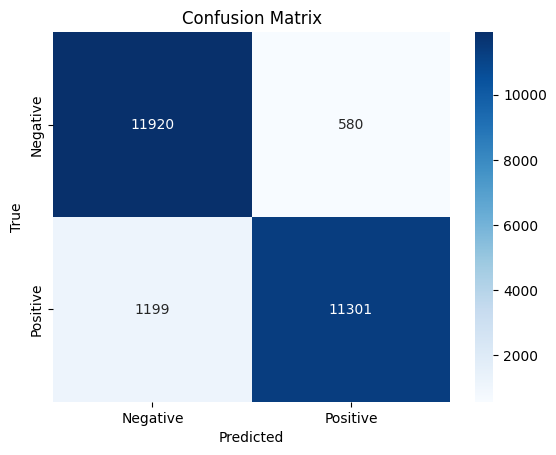

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Define a list of example sentences for sentiment prediction
example_sentences = [
    "I absolutely loved this movie! The performances were outstanding.",
    "This was the worst film I have ever seen. Completely disappointing.",
    "The plot was intriguing, but the characters were underdeveloped.",
    "An average movie with some good moments and some bad ones.",
    "I was not impressed by the storyline or the acting.",
    "Fantastic visuals and a gripping story. Highly recommend!",
    "The movie was okay, nothing special but not terrible either.",
    "I didn't enjoy this movie at all. It was a waste of time.",
    "A masterpiece of modern cinema. Truly inspiring.",
    "Mediocre at best. I expected much more from this director."
]

In [26]:
def predict_sentence(sentence):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        
    logits = output.logits
    pred_id = torch.argmax(logits, dim=1).item()
    
    label = "positive" if pred_id == 1 else "negative"
    return label

In [27]:
import pandas as pd

# Create a DataFrame to display sentences and their predicted sentiments
demo_results = []

for sentence in example_sentences:
    prediction = predict_sentence(sentence)
    demo_results.append({"Sentence": sentence, "Predicted Sentiment": prediction})

df_demo = pd.DataFrame(demo_results)
df_demo

,Sentence,Predicted Sentiment
0,I absolutely loved this movie! The performance...,positive
1,This was the worst film I have ever seen. Comp...,negative
2,"The plot was intriguing, but the characters we...",positive
3,An average movie with some good moments and so...,negative
4,I was not impressed by the storyline or the ac...,negative
5,Fantastic visuals and a gripping story. Highly...,positive
6,"The movie was okay, nothing special but not te...",negative
7,I didn't enjoy this movie at all. It was a was...,negative
8,A masterpiece of modern cinema. Truly inspiring.,positive
9,Mediocre at best. I expected much more from th...,negative
